In [1]:

import pandas as pd 
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.model_selection import StratifiedKFold,  GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import gc



# Базовая модель

WAU = 0.03325497896395779; UpLift at 30% 0.030237510784074884


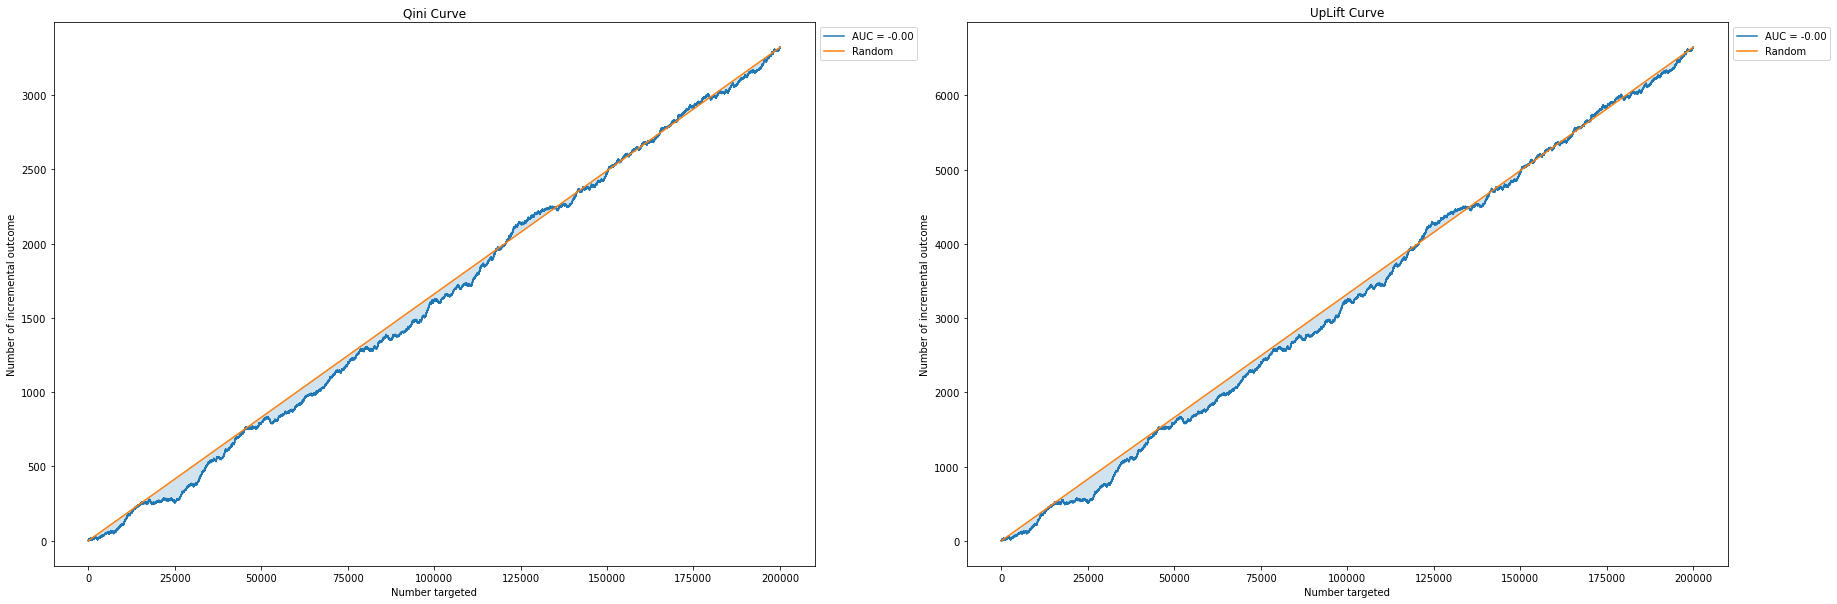

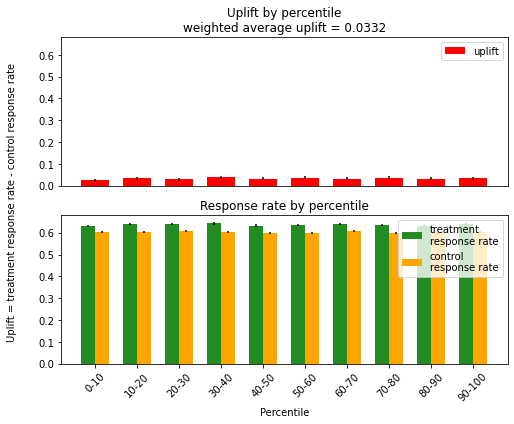

In [2]:


df= pd.read_csv(r'D:\Documents\GitHub\MastersDegree\Datasets\X5\data\X5_clients_data_train.csv')
df.describe()
med = df.age.median()
df.age = df.age.apply(lambda x: x if((x >= 16) and (x <= 90)) else med)
df.age = df.age.fillna(med)
df.Mean_diffs = df.Mean_diffs.fillna(df.Mean_diffs.median()) 
df = df.fillna(0)
df.describe()

df = df.drop(['MeanItemCost', 'NewComerFlag', 'client_id'], axis = 1)
# X = df.iloc[:, 0:-1].set_index('client_id')
# y = df.iloc[:, [0, -1]].set_index('client_id')
# del df
# gc.collect()
treat = df.treatment_flg.values
y = df.iloc[:, -1].values
del df
gc.collect()

from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt


y_pred = np.random.uniform(-1, 1, len(treat)).tolist()
gc.collect()
wau = weighted_average_uplift(y_true=y , uplift=y_pred,
                        treatment=treat)
uplift_overall = uplift_at_k(y_true=y , uplift=y_pred,
                        treatment=treat, strategy='by_group', k=0.3)

print(f'WAU = {wau}; UpLift at 30% {uplift_overall}')
fig, ax = plt.subplots(1, 2, figsize = (30, 10))
ax[0].set_title('Qini Curve')
ax[1].set_title('UpLift Curve')
plot_qini_curve(y_true=y , uplift=y_pred,
                        treatment=treat, ax = ax[0], perfect=False)
gc.collect()
plot_uplift_curve(y_true=y , uplift=y_pred,
                        treatment=treat, ax = ax[1], perfect=False)
gc.collect()
gc.collect()
gc.collect()
plt.savefig(f"Plots/Base model Split.png")

plot_uplift_by_percentile(y_true=y , uplift=y_pred,
                        treatment=treat, kind='bar')
plt.savefig(f"Plots/Base model Procentile.png")






# Метод одной модели

In [48]:

df= pd.read_csv(r'D:\Documents\GitHub\MastersDegree\Datasets\X5\data\X5_clients_data_train.csv')
df.describe()

,MeanChk,MeanItemCost,Chks,last_chk_ago,Mean_TOP_1_BRAND,Mean_TOP_2_BRAND,Mean_TOP_3_BRAND,Mean_TOP_4_BRAND,Mean_TOP_5_BRAND,Mean_TOP_1_VENDOR,...,Mean_TOP_4_LVL,Mean_alc,Mean_CTM,Mean_netto,Mean_diffs,age,NewComerFlag,Gender,treatment_flg,target
count,200039.000000,200039.000000,200039.000000,200039.000000,200039.000000,200039.000000,200039.000000,200039.000000,200039.000000,200039.000000,...,200039.000000,200039.000000,200039.000000,200039.000000,196219.000000,200039.000000,200039.000000,200039.000000,200039.000000,200039.000000
mean,495.783222,84.241407,20.120821,5.828868,0.131215,0.045033,0.057777,0.044185,0.038410,0.148765,...,0.000164,0.025098,0.148765,3.512542,8.900076,46.417329,1.530102,-0.296547,0.499808,0.619889
std,374.548483,47.634880,17.732130,5.668016,0.097788,0.065461,0.055120,0.044964,0.054367,0.097857,...,0.002905,0.062164,0.097857,3.508437,10.557729,49.532475,0.651553,0.737329,0.500001,0.485415
min,1.040000,0.065000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-7491.000000,0.000000,-1.000000,0.000000,0.000000
25%,261.290000,61.827298,8.000000,1.000000,0.063268,0.000000,0.021877,0.007092,0.002709,0.083333,...,0.000000,0.000000,0.083333,1.914694,3.000000,34.000000,1.000000,-1.000000,0.000000,0.000000
50%,393.999846,76.025910,15.000000,4.000000,0.112962,0.022523,0.046759,0.031716,0.022222,0.133333,...,0.000000,0.000000,0.133333,2.828375,6.000000,45.000000,2.000000,0.000000,0.000000,1.000000
75%,608.740000,95.502247,27.000000,9.000000,0.177366,0.059259,0.078789,0.070426,0.051314,0.194444,...,0.000000,0.021611,0.194444,4.206917,10.000000,59.000000,2.000000,0.000000,1.000000,1.000000
max,7694.000000,4426.800000,320.000000,22.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.500000,1.000000,1.000000,299.302000,113.000000,1852.000000,2.000000,1.000000,1.000000,1.000000


In [49]:
med = df.age.median()
df.age = df.age.apply(lambda x: x if((x >= 16) and (x <= 90)) else med)
df.age = df.age.fillna(med)
df.Mean_diffs = df.Mean_diffs.fillna(df.Mean_diffs.median()) 
df = df.fillna(0)

In [50]:
df.describe()

,MeanChk,MeanItemCost,Chks,last_chk_ago,Mean_TOP_1_BRAND,Mean_TOP_2_BRAND,Mean_TOP_3_BRAND,Mean_TOP_4_BRAND,Mean_TOP_5_BRAND,Mean_TOP_1_VENDOR,...,Mean_TOP_4_LVL,Mean_alc,Mean_CTM,Mean_netto,Mean_diffs,age,NewComerFlag,Gender,treatment_flg,target
count,200039.000000,200039.000000,200039.000000,200039.000000,200039.000000,200039.000000,200039.000000,200039.000000,200039.000000,200039.000000,...,200039.000000,200039.000000,200039.000000,200039.000000,200039.000000,200039.000000,200039.000000,200039.000000,200039.000000,200039.000000
mean,495.783222,84.241407,20.120821,5.828868,0.131215,0.045033,0.057777,0.044185,0.038410,0.148765,...,0.000164,0.025098,0.148765,3.512542,8.844695,46.509161,1.530102,-0.296547,0.499808,0.619889
std,374.548483,47.634880,17.732130,5.668016,0.097788,0.065461,0.055120,0.044964,0.054367,0.097857,...,0.002905,0.062164,0.097857,3.508437,10.463966,15.715009,0.651553,0.737329,0.500001,0.485415
min,1.040000,0.065000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,16.000000,0.000000,-1.000000,0.000000,0.000000
25%,261.290000,61.827298,8.000000,1.000000,0.063268,0.000000,0.021877,0.007092,0.002709,0.083333,...,0.000000,0.000000,0.083333,1.914694,3.000000,34.000000,1.000000,-1.000000,0.000000,0.000000
50%,393.999846,76.025910,15.000000,4.000000,0.112962,0.022523,0.046759,0.031716,0.022222,0.133333,...,0.000000,0.000000,0.133333,2.828375,6.000000,45.000000,2.000000,0.000000,0.000000,1.000000
75%,608.740000,95.502247,27.000000,9.000000,0.177366,0.059259,0.078789,0.070426,0.051314,0.194444,...,0.000000,0.021611,0.194444,4.206917,10.000000,59.000000,2.000000,0.000000,1.000000,1.000000
max,7694.000000,4426.800000,320.000000,22.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.500000,1.000000,1.000000,299.302000,113.000000,90.000000,2.000000,1.000000,1.000000,1.000000


In [51]:
df = df.drop(['MeanItemCost', 'NewComerFlag', 'client_id'], axis = 1)

In [52]:
# X = df.iloc[:, 0:-1].set_index('client_id')
# y = df.iloc[:, [0, -1]].set_index('client_id')
# del df
# gc.collect()
treat = df.treatment_flg.values
X = df.iloc[:, 0:-1].values
X = (X - X.mean()) / X.std()
y = df.iloc[:, -1].values
del df
gc.collect()

66300

In [53]:
t_0 = np.argwhere(treat == 0)
t_1 = np.argwhere(treat == 1)
y_c = y[t_0]
len(y_c[y_c == 1]) / len(y_c)

0.6032800975434248

In [54]:
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt



Split 1; WAU = 0.03174966736650516; UpLift at 30% 0.021337077611904842
Split 2; WAU = 0.02845858892450361; UpLift at 30% 0.02205042663758261
Split 3; WAU = 0.03704412296895797; UpLift at 30% 0.043241073895962656
Split 4; WAU = 0.03397659229369775; UpLift at 30% 0.027960909750649243
Split 5; WAU = 0.034671745989312004; UpLift at 30% 0.033333066707682546


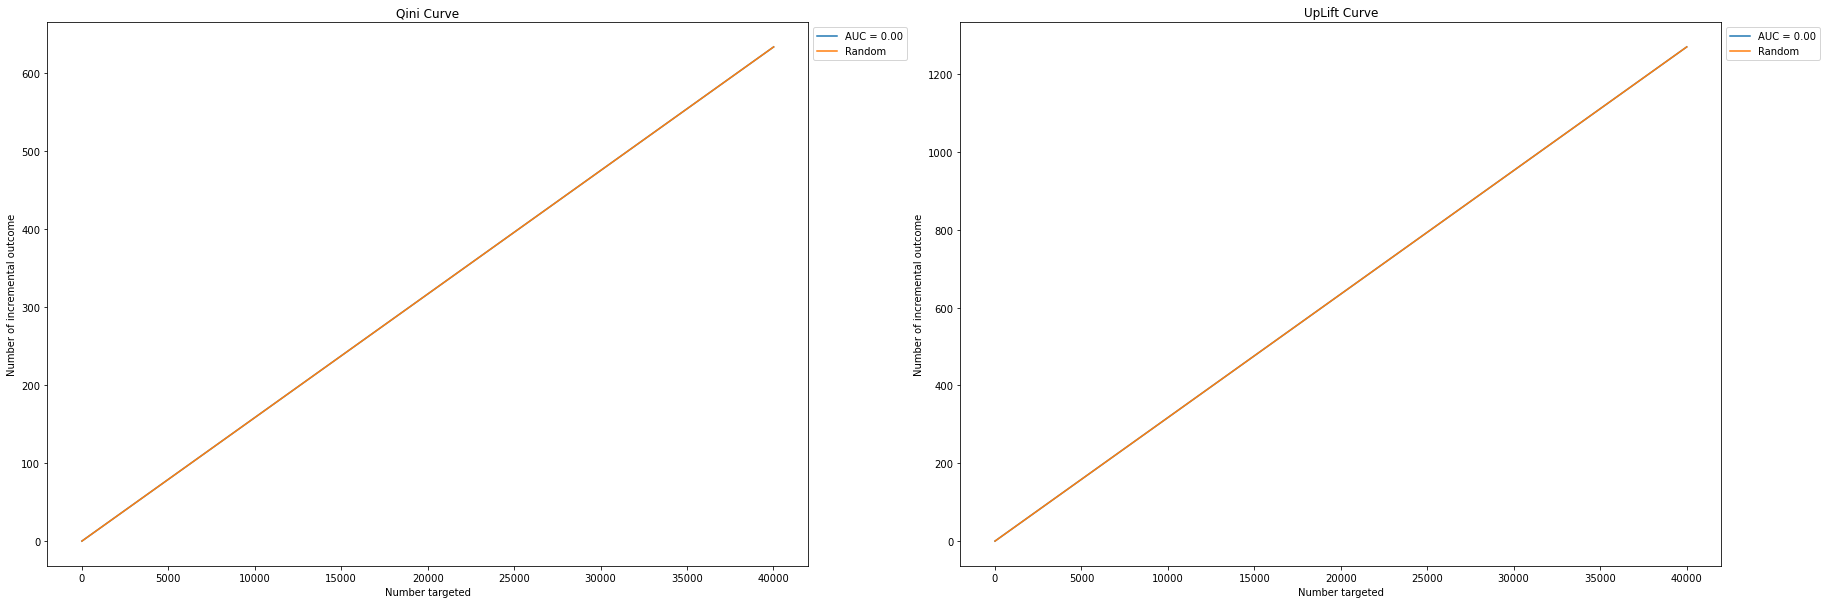

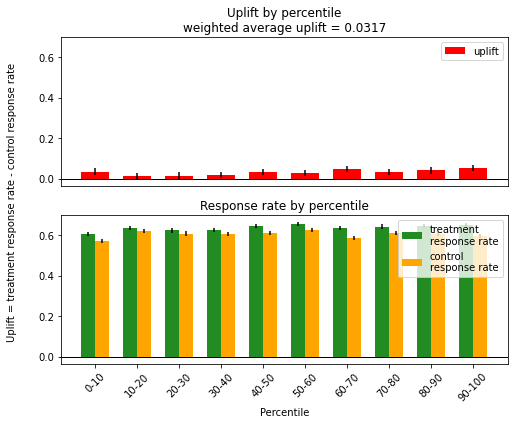

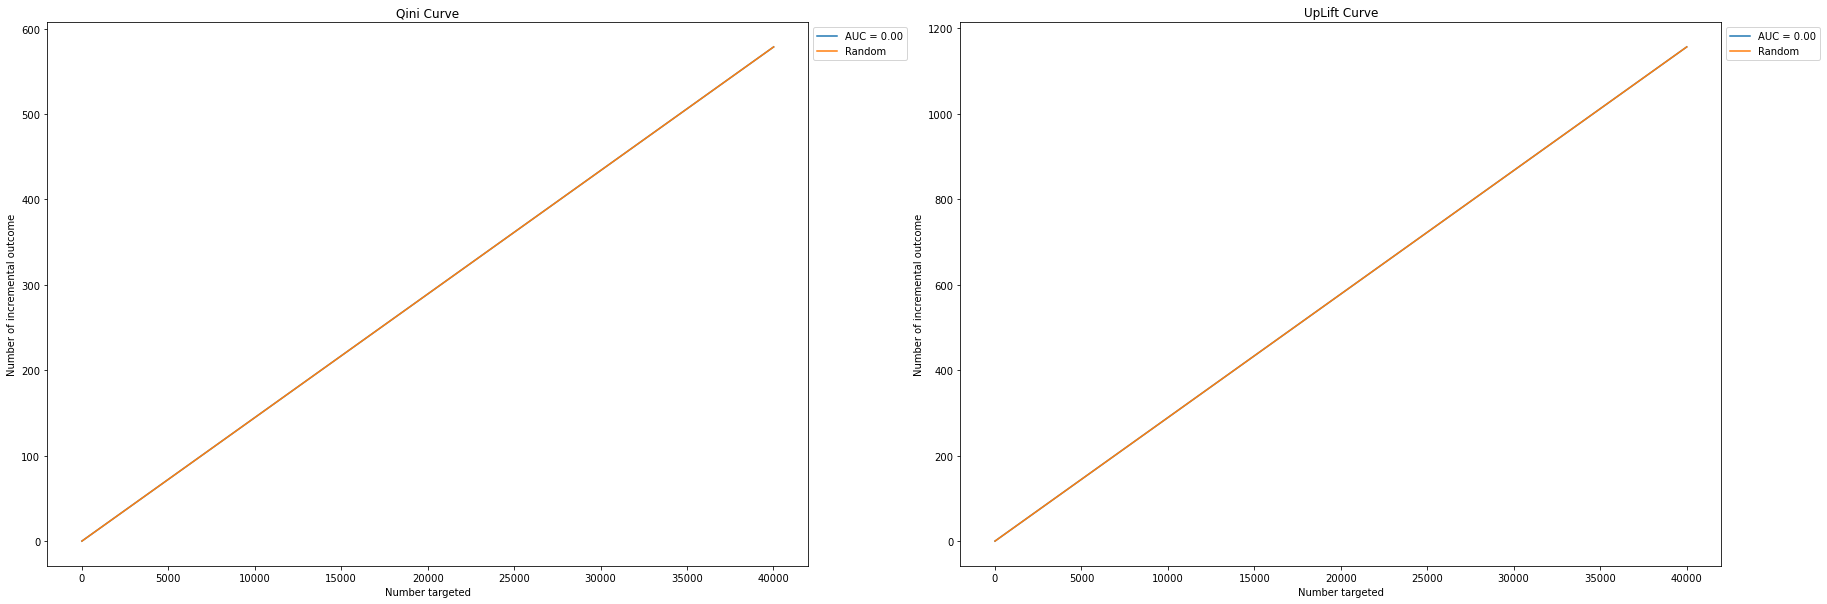

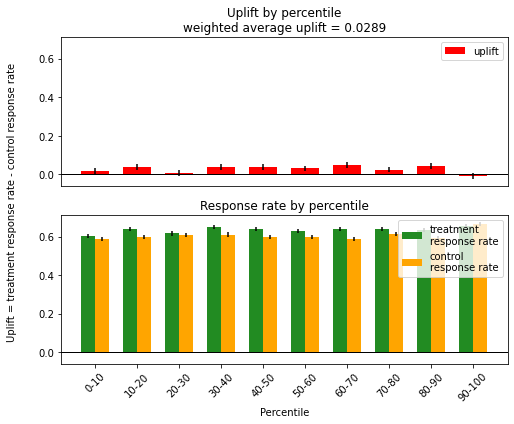

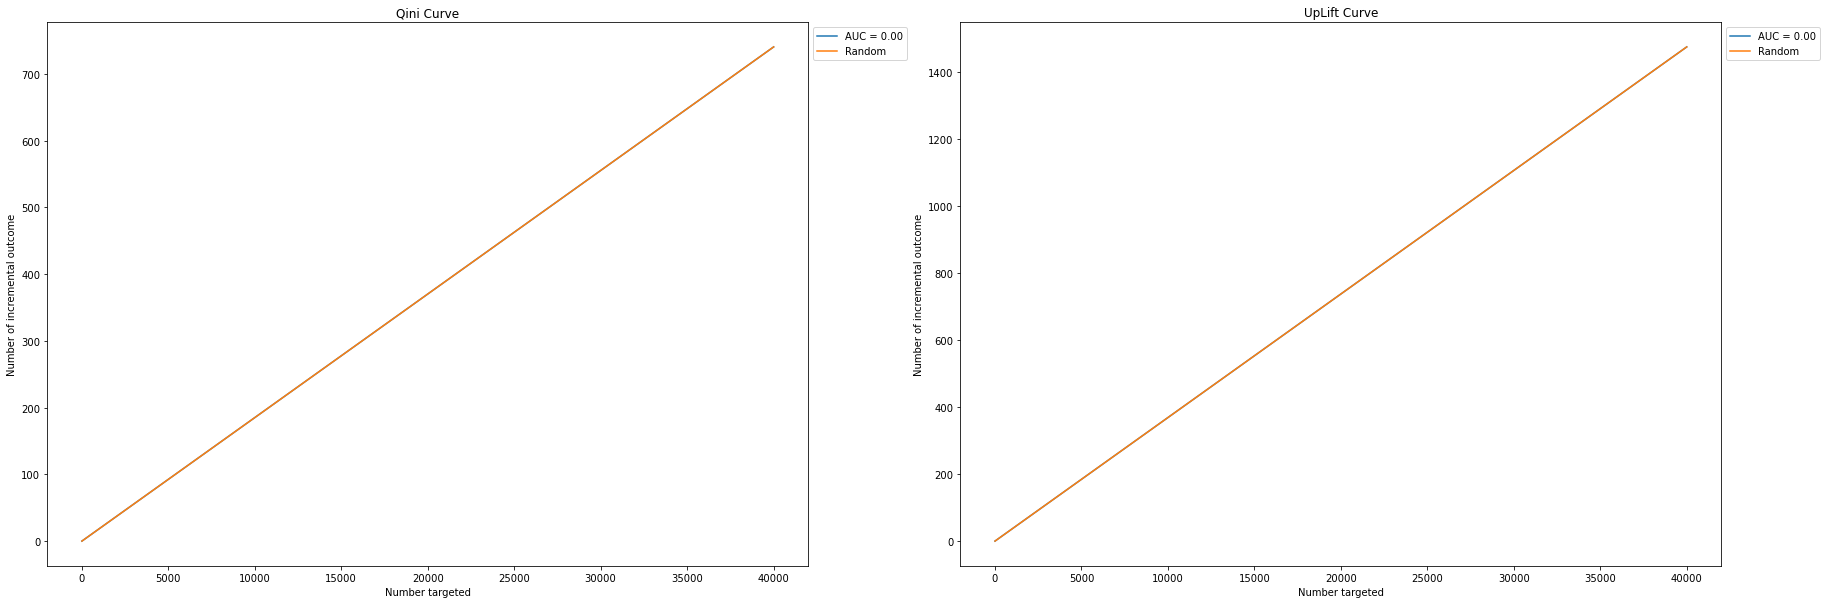

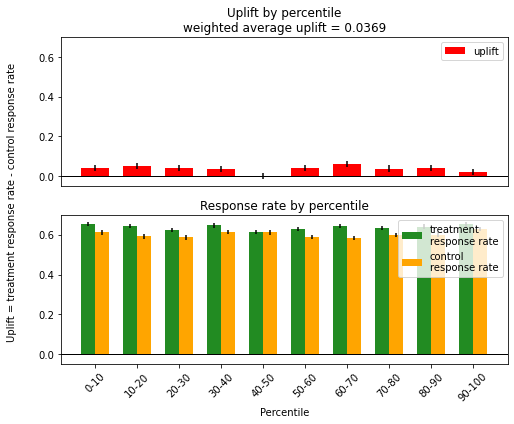

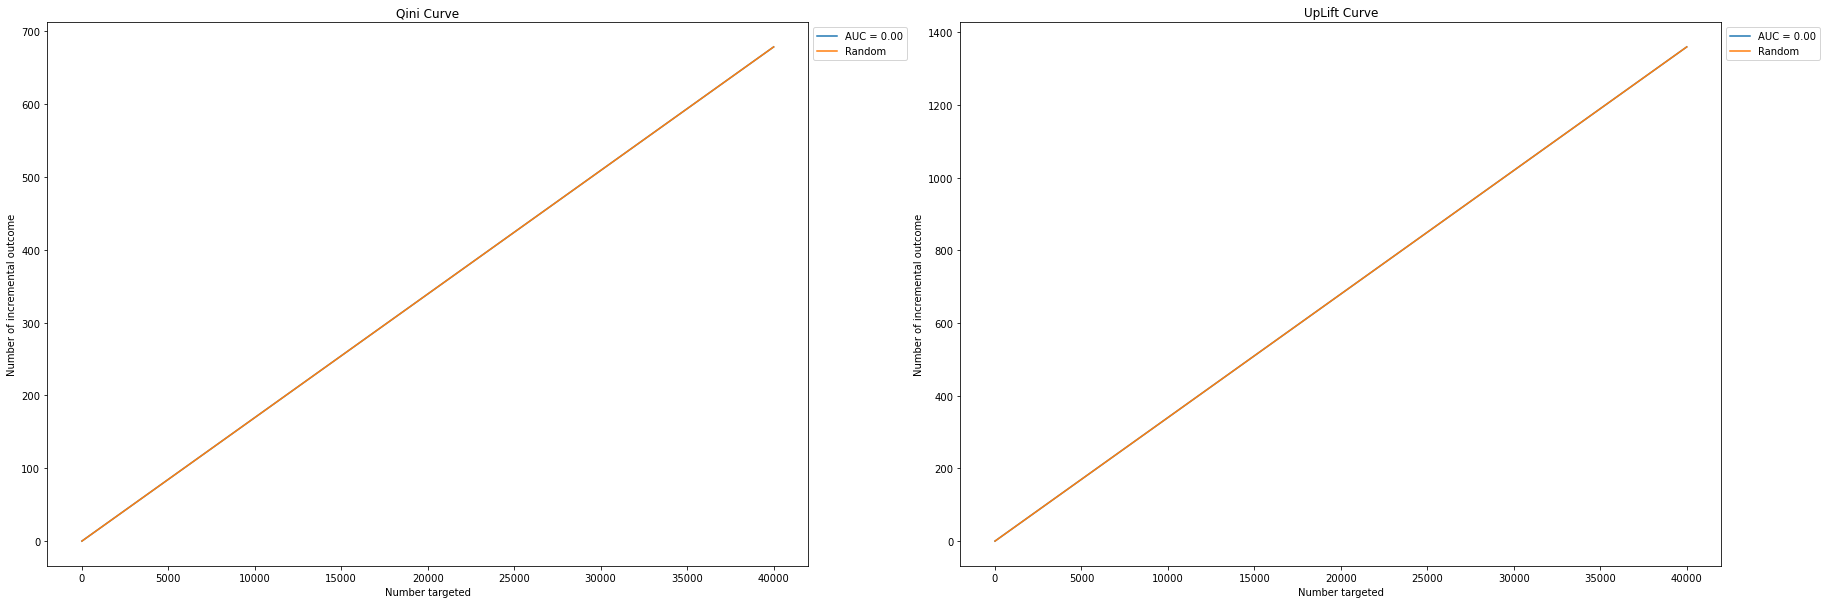

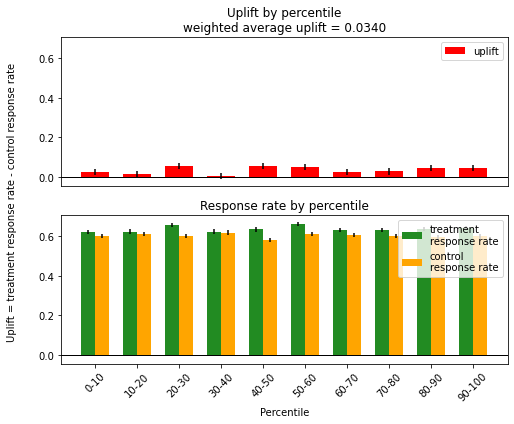

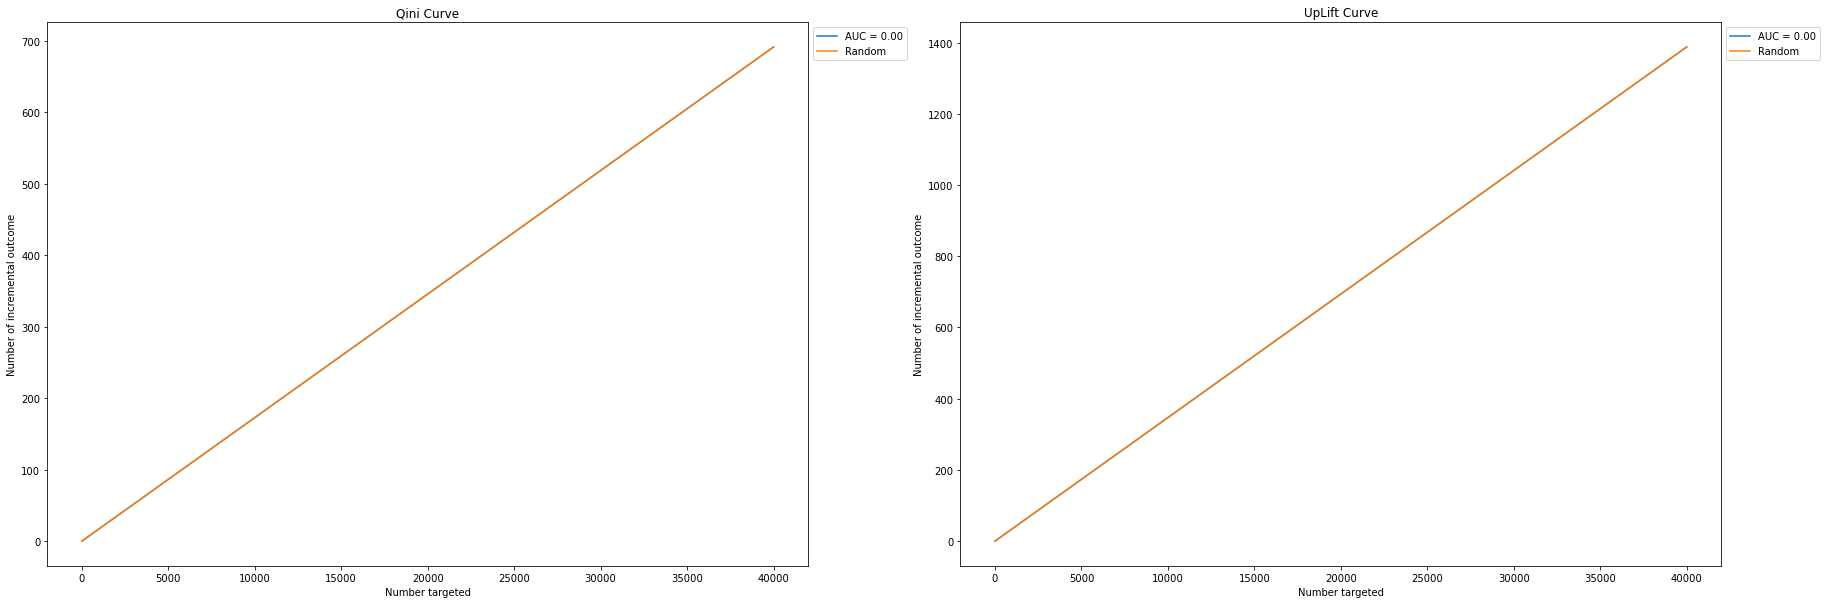

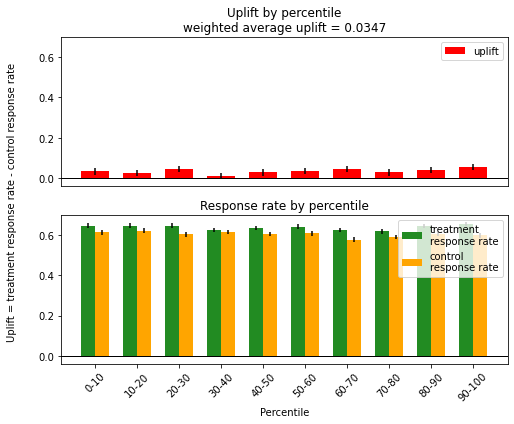

In [57]:
#Default data
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X, y)
metrics = {'wau':[], 'uplift_k':[]}
i = 0


for train_index, test_index in skf.split(X, y):
      gc.collect()
      X_train_, X_test_ = X[train_index], X[test_index]
      y_train_, y_test_ = y[train_index], y[test_index]
      clf = CatBoostClassifier(verbose = 0)
      clf.fit(X_train_, y_train_)
      X_test_[:, -1] = 1#np.ones(len(test_index))
      y_pred1 = clf.predict_proba(X_test_).T[1]
      X_test_[:, -1] = 0#np.ones(len(test_index))
      y_pred0 = clf.predict_proba(X_test_).T[1]
      y_pred = y_pred1 - y_pred0
      del clf
      del X_train_
      del y_train_
      del X_test_
      gc.collect()
      wau = weighted_average_uplift(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index])
      uplift_overall = uplift_at_k(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index], strategy='by_group', k=0.3)
      metrics['wau'].append(wau)
      metrics['uplift_k'].append(uplift_overall)
      i += 1
      print(f'Split {i}; WAU = {wau}; UpLift at 30% {uplift_overall}')
      fig, ax = plt.subplots(1, 2, figsize = (30, 10))
      ax[0].set_title('Qini Curve')
      ax[1].set_title('UpLift Curve')
      plot_qini_curve(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index], ax = ax[0], perfect=False)
      gc.collect()
      plot_uplift_curve(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index], ax = ax[1], perfect=False)
      gc.collect()
      gc.collect()
      gc.collect()
      plt.savefig(f"Plots/One model Split {i}.png")

      plot_uplift_by_percentile(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index], kind='bar')
      plt.savefig(f"Plots/One model Procentile Split {i}.png")



In [58]:
wau = np.round(np.mean(metrics['wau']), 4)
uplift_overall = np.round(np.mean(metrics['uplift_k']), 4)
print(f'Mean WAU = {wau}; Mean UpLift 30% = {uplift_overall}')

Mean WAU = 0.0332; Mean UpLift 30% = 0.0296


In [59]:
gc.collect()

66391

# Метод двух моделей

In [40]:


df= pd.read_csv(r'D:\Documents\GitHub\MastersDegree\Datasets\X5\data\X5_clients_data_train.csv')
df.describe()
med = df.age.median()
df.age = df.age.apply(lambda x: x if((x >= 16) and (x <= 90)) else med)
df.age = df.age.fillna(med)
df.Mean_diffs = df.Mean_diffs.fillna(df.Mean_diffs.median()) 
df = df.fillna(0)
df.describe()

df = df.drop(['MeanItemCost', 'NewComerFlag', 'client_id'], axis = 1)
# X = df.iloc[:, 0:-1].set_index('client_id')
# y = df.iloc[:, [0, -1]].set_index('client_id')
# del df
# gc.collect()
treat = df.treatment_flg.values
X = df.iloc[:, 0:-1].values
X = (X - X.mean()) / X.std()
y = df.iloc[:, -1].values
del df
gc.collect()
X
y
# X_train, X_test, y_train, y_test = train_test_split(X, y)
# output.enable_custom_widget_manager()
# grid = {'learning_rate':  np.linspace(0, 0.05, 10)[1:-1],
#         'depth': [4, 6, 10],
#         'l2_leaf_reg': [1, 3, 5, 7, 9]}
# clf = CatBoostClassifier(verbose = 0)  
# grid_search_result = clf.grid_search(grid, 
#                                        X=X_train, 
#                                        y=y_train, 
#                                        plot=True)
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt







In [41]:

indxs = np.argwhere(X.T[-1] == 0)
indxs

array([], shape=(0, 1), dtype=int64)

Split 1; WAU = 0.03259671002053004; UpLift 30% 0.047863253845178866
Split 2; WAU = 0.027067973858801195; UpLift 30% 0.04937386772249153
Split 3; WAU = 0.03454492798991928; UpLift 30% 0.050823974770416
Split 4; WAU = 0.03492936534829678; UpLift 30% 0.04714614906275105
Split 5; WAU = 0.034333157970141644; UpLift 30% 0.04046063691646551
Mean WAU = 0.0327; Mean UpLift 30% = 0.0471


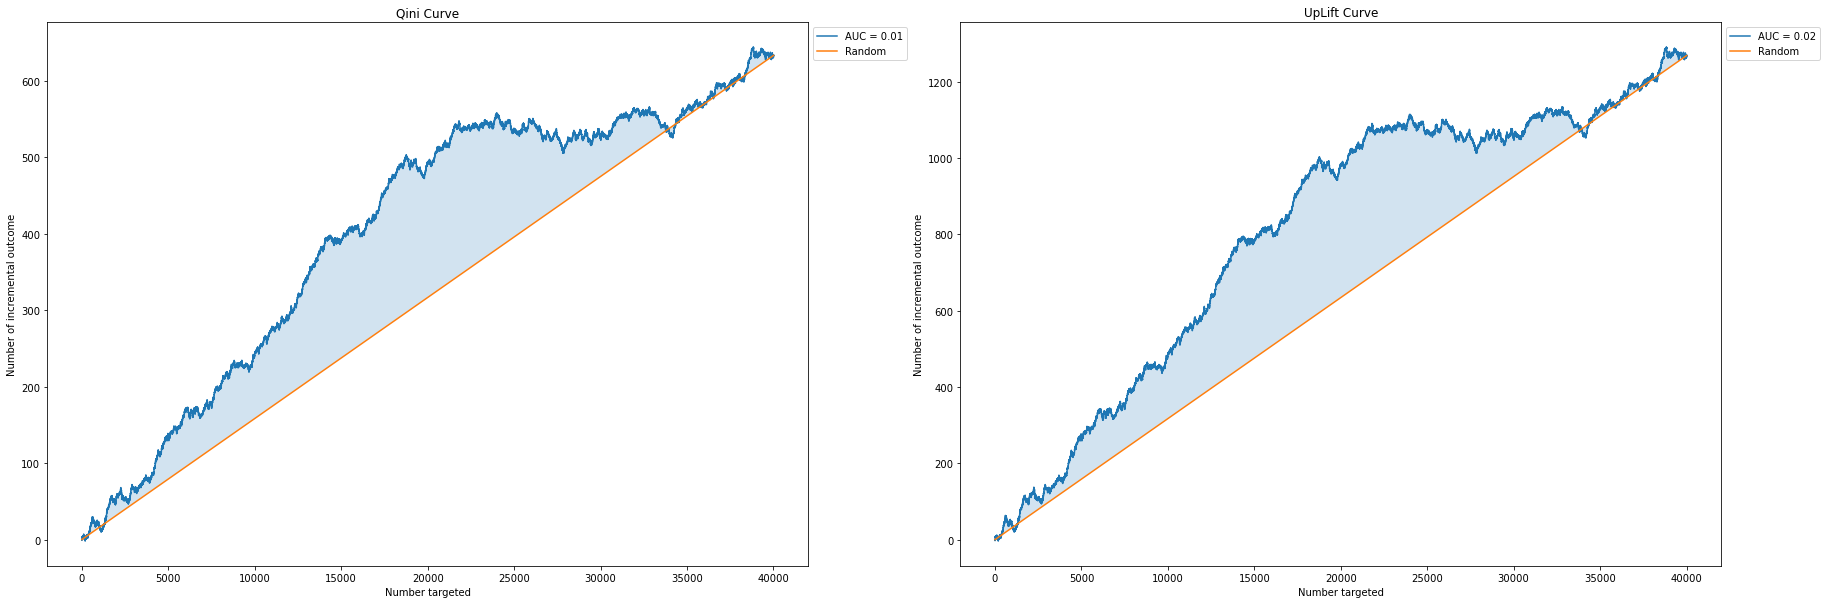

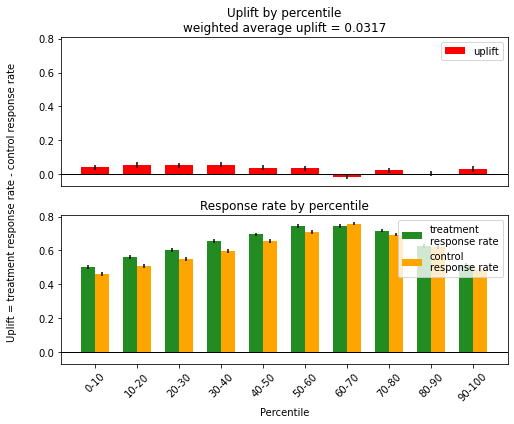

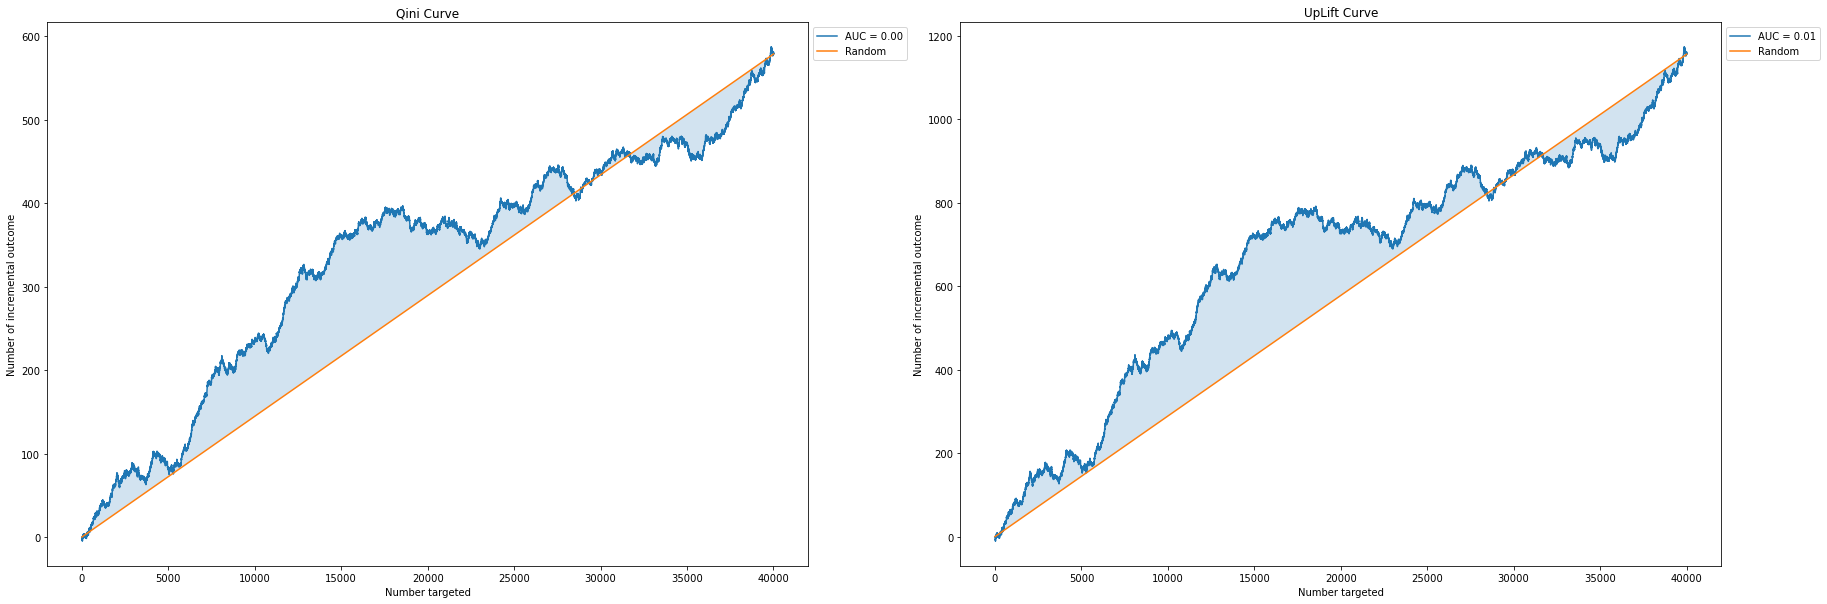

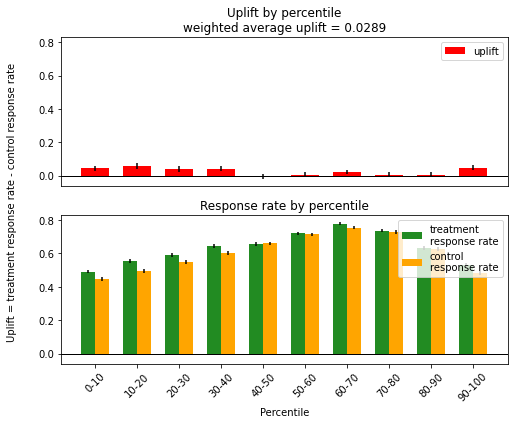

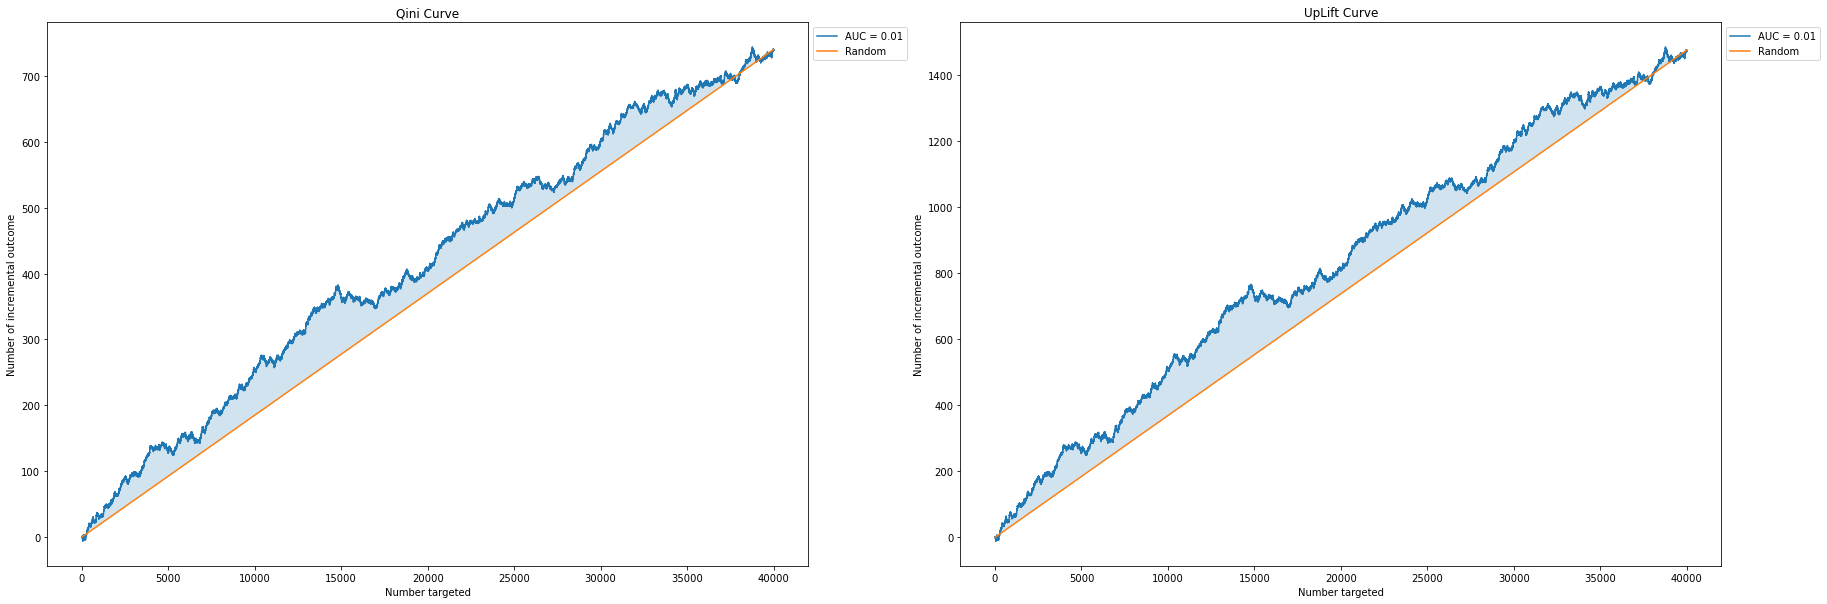

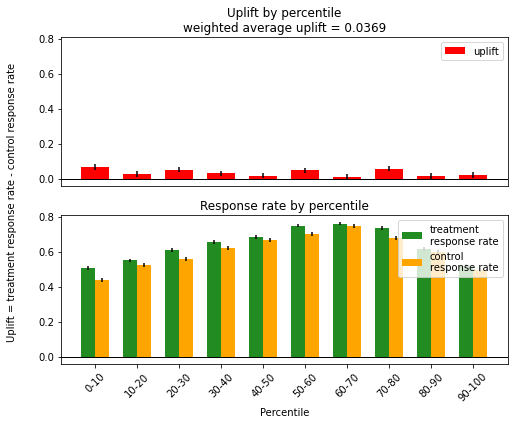

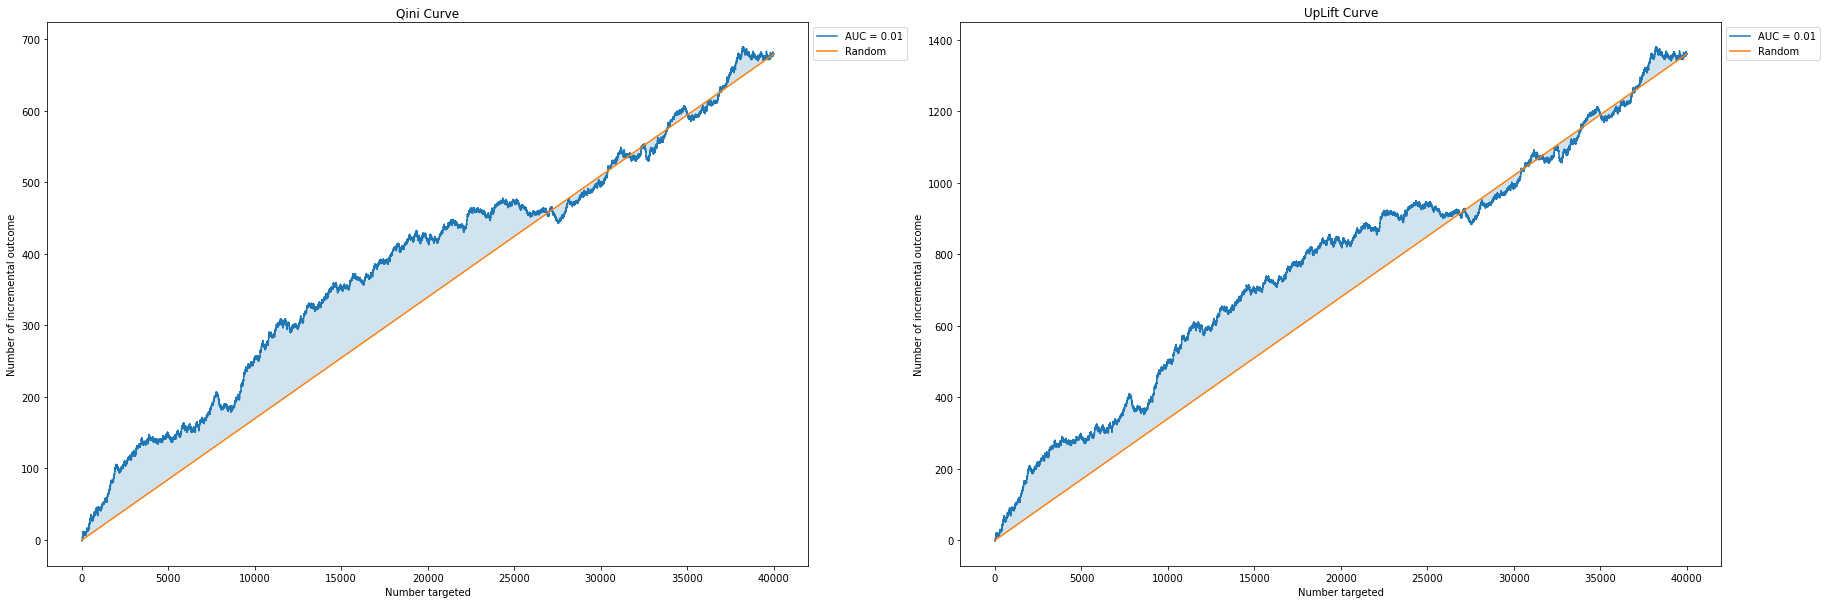

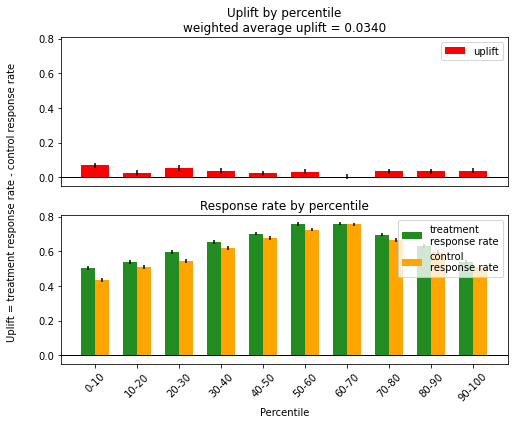

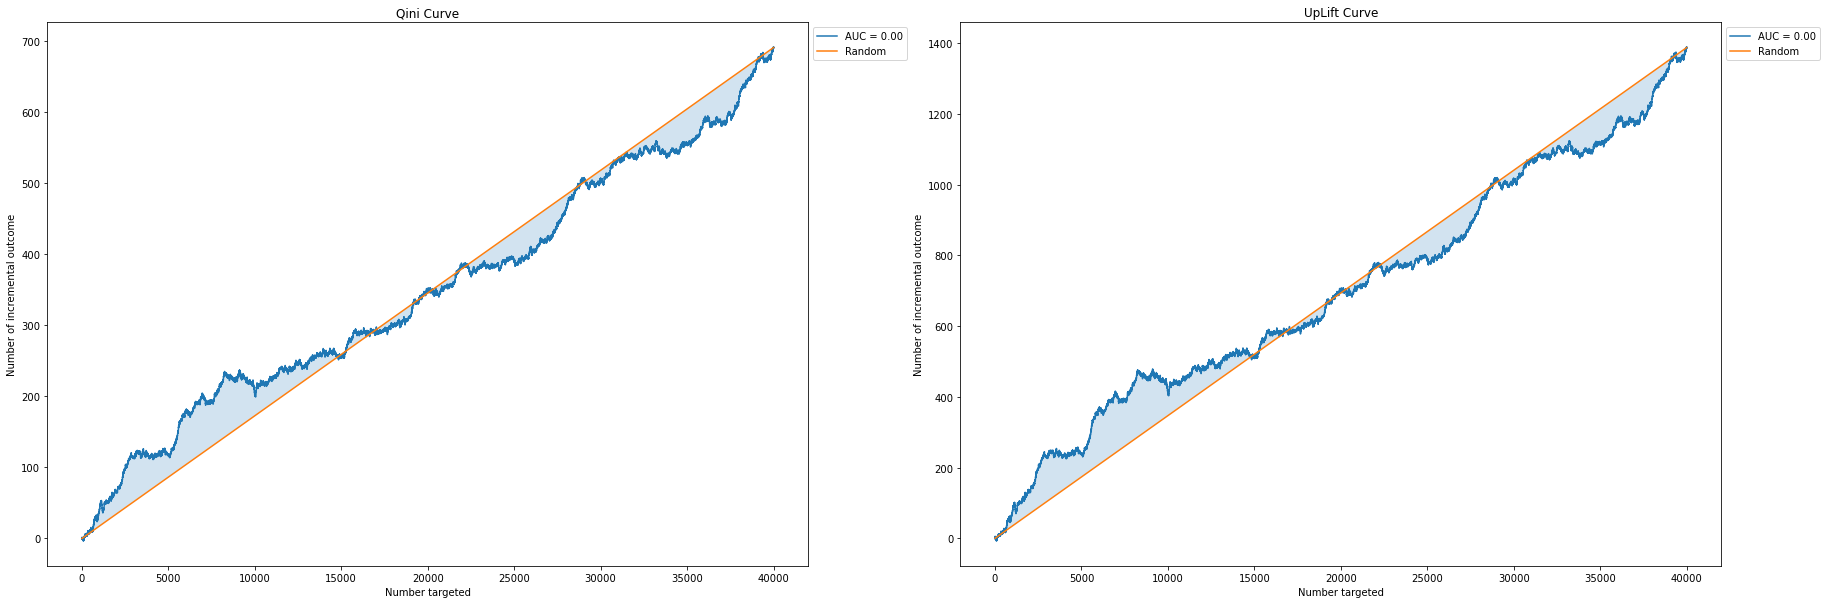

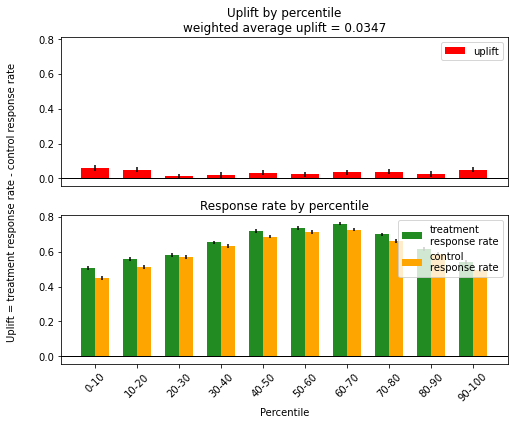

In [42]:
#Default data
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X, y)
metrics = {'wau':[], 'uplift_k':[]}
i = 0

for train_index, test_index in skf.split(X, y):
      gc.collect()
      X_train_, X_test_ = X[train_index], X[test_index]
      y_train_, y_test_ = y[train_index], y[test_index]
      t_0 = np.argwhere(treat[train_index] == 0)
      t_1 = np.argwhere(treat[train_index] == 1)
      clf0 = CatBoostClassifier(verbose = 0, class_weights= [0.5, 0.5] )
      clf0.fit(np.squeeze(X_train_[t_0]), np.squeeze(y_train_[t_0]))
      clf1 = CatBoostClassifier(verbose = 0, class_weights= [0.5, 0.5] )
      clf1.fit(np.squeeze(X_train_[t_1]), np.squeeze(y_train_[t_1]))
      y_pred1 = clf1.predict_proba(X_test_).T[1]
      y_pred0 = clf0.predict_proba(X_test_).T[1]
      y_pred = y_pred1 - y_pred0
      del clf0
      del clf1
      del X_train_
      del y_train_
      del X_test_
      gc.collect()
      wau = weighted_average_uplift(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index])
      uplift_overall = uplift_at_k(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index], strategy='by_group', k=0.3)
      metrics['wau'].append(wau)
      metrics['uplift_k'].append(uplift_overall)
      i += 1
      print(f'Split {i}; WAU = {wau}; UpLift 30% {uplift_overall}')
      fig, ax = plt.subplots(1, 2, figsize = (30, 10))
      ax[0].set_title('Qini Curve')
      ax[1].set_title('UpLift Curve')
      plot_qini_curve(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index], ax = ax[0], perfect=False)
      gc.collect()
      plot_uplift_curve(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index], ax = ax[1], perfect=False)
      gc.collect()
      gc.collect()
      gc.collect()
      plt.savefig(f"Plots/Two model Split {i}.png")

      plot_uplift_by_percentile(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index], kind='bar')
      plt.savefig(f"Plots/Two model Procentile Split {i}.png")


wau = np.round(np.mean(metrics['wau']), 4)
uplift_overall = np.round(np.mean(metrics['uplift_k']), 4)
print(f'Mean WAU = {wau}; Mean UpLift 30% = {uplift_overall}')

In [43]:
gc.collect()

67004

# Метод трансформации класса

In [44]:


df= pd.read_csv(r'D:\Documents\GitHub\MastersDegree\Datasets\X5\data\X5_clients_data_train.csv')
med = df.age.median()
df.age = df.age.apply(lambda x: x if((x >= 16) and (x <= 90)) else med)
df.age = df.age.fillna(med)
df.Mean_diffs = df.Mean_diffs.fillna(df.Mean_diffs.median()) 
df = df.fillna(0)
df.describe()
display(df)







,client_id,MeanChk,MeanItemCost,Chks,last_chk_ago,Mean_TOP_1_BRAND,Mean_TOP_2_BRAND,Mean_TOP_3_BRAND,Mean_TOP_4_BRAND,Mean_TOP_5_BRAND,...,Mean_TOP_4_LVL,Mean_alc,Mean_CTM,Mean_netto,Mean_diffs,age,NewComerFlag,Gender,treatment_flg,target
0,e2652509f4,300.000000,73.065146,30,4,0.096885,0.085866,0.040000,0.102493,0.131647,...,0.0,0.000000,0.349934,2.714800,3.0,34.0,2,-1,1,0
1,7cef4b564e,192.403846,71.013718,13,4,0.211538,0.064103,0.000000,0.000000,0.201282,...,0.0,0.000000,0.166667,1.507615,8.0,70.0,2,1,1,0
2,1292a2aeae,506.583571,90.585577,14,2,0.079762,0.000000,0.048810,0.081548,0.053571,...,0.0,0.008929,0.135119,2.992000,7.0,58.0,2,0,0,0
3,bbadac1567,1172.320000,72.489040,3,20,0.082935,0.084211,0.000000,0.114514,0.084211,...,0.0,0.000000,0.266507,7.598667,17.0,41.0,0,-1,1,0
4,09c55f2885,137.880000,59.411250,40,0,0.416667,0.023750,0.112917,0.000000,0.000000,...,0.0,0.020833,0.095417,1.060850,2.0,18.0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200034,a04b6cc272,262.096774,116.929800,31,5,0.118280,0.036866,0.043318,0.000000,0.089286,...,0.0,0.000000,0.146352,1.340742,3.0,59.0,2,-1,1,0
200035,f570c011c7,251.000000,88.792803,22,1,0.173485,0.074242,0.056061,0.014773,0.023864,...,0.0,0.136364,0.144697,1.893409,4.0,47.0,2,0,1,1
200036,e7ccdb161f,388.419231,80.784188,13,5,0.102564,0.030342,0.070513,0.023810,0.000000,...,0.0,0.044872,0.156716,1.930462,8.0,55.0,2,-1,1,1
200037,b8464507df,165.374412,84.167661,68,0,0.112815,0.014706,0.010294,0.000000,0.175665,...,0.0,0.031863,0.037885,1.116956,1.0,65.0,2,-1,1,1


In [45]:
df = df.drop(['MeanItemCost', 'NewComerFlag', 'client_id'], axis = 1)
# X = df.iloc[:, 0:-1].set_index('client_id')
# y = df.iloc[:, [0, -1]].set_index('client_id')
# del df
# gc.collect()
treat = df.treatment_flg.values
targ = df.target.values
treat

array([1, 1, 0, ..., 1, 1, 0], dtype=int64)

In [46]:

p = df[df.treatment_flg == 1].shape[0] / df.shape[0]
X = df.iloc[:, 0:-2].values
X = (X - X.mean()) / X.std()
y = df.target * (df.treatment_flg - p) / (1- p) / p
y = y.values
del df
gc.collect()
print(X)
print(y)
print(p)
# X_train, X_test, y_train, y_test = train_test_split(X, y)
# output.enable_custom_widget_manager()
# grid = {'learning_rate':  np.linspace(0, 0.05, 10)[1:-1],
#         'depth': [4, 6, 10],
#         'l2_leaf_reg': [1, 3, 5, 7, 9]}
# clf = CatBoostClassifier(verbose = 0)  
# grid_search_result = clf.grid_search(grid, 
#                                        X=X_train, 
#                                        y=y_train, 
#                                        plot=True)
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt


[[ 2.40494708e+00  7.92625737e-02 -1.44692231e-01 ... -1.53305877e-01
   1.13717159e-01 -1.87760462e-01]
 [ 1.47815187e+00 -6.71694138e-02 -1.44692231e-01 ... -1.10237645e-01
   4.23808427e-01 -1.70533170e-01]
 [ 4.18438490e+00 -5.85557675e-02 -1.61919523e-01 ... -1.18851292e-01
   3.20444671e-01 -1.79146816e-01]
 ...
 [ 3.16655907e+00 -6.71694138e-02 -1.36078584e-01 ... -1.10237645e-01
   2.94603732e-01 -1.87760462e-01]
 [ 1.24532988e+00  4.06581134e-01 -1.79146816e-01 ... -1.70533170e-01
   3.80740195e-01 -1.87760462e-01]
 [ 1.42971754e+00  1.89670494e-02 -5.85557675e-02 ... -1.44692231e-01
   1.73975679e-03 -1.79146816e-01]]
[ 0.          0.         -0.         ...  2.00077015  2.00077015
 -1.99923045]
0.4998075375301816


Split 1; WAU = 0.03183037515491843; UpLift 30% = 0.04632343548851103
Split 2; WAU = 0.028891573413703558; UpLift 30% = 0.04214264991545569
Split 3; WAU = 0.03719043127738924; UpLift 30% = 0.0435835671139565
Split 4; WAU = 0.03364442600398702; UpLift 30% = 0.02762543946520868
Split 5; WAU = 0.033981824840697214; UpLift 30% = 0.04075460081284554
Mean WAU = 0.0331; Mean UpLift 30% = 0.0401


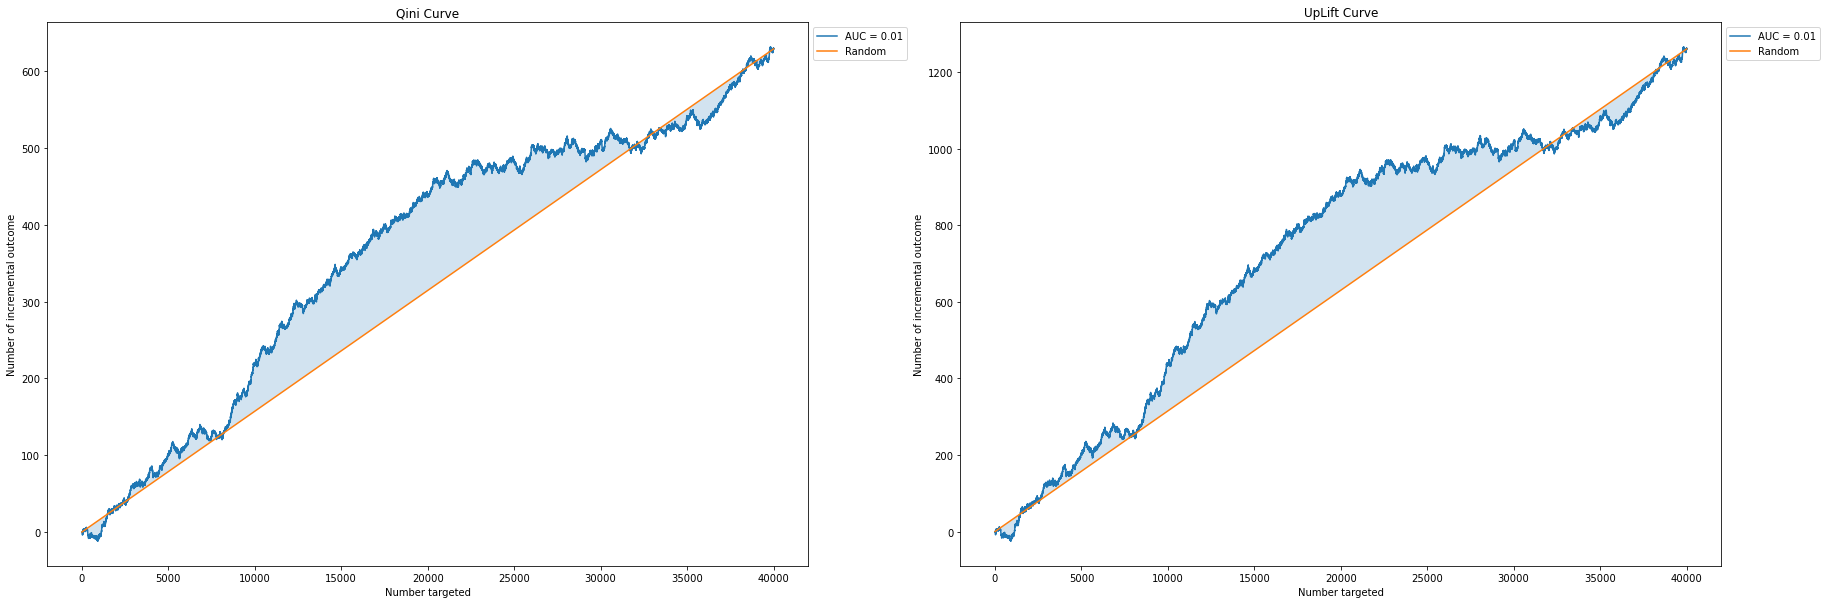

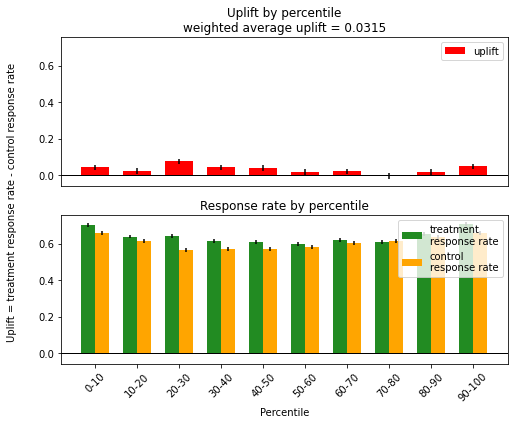

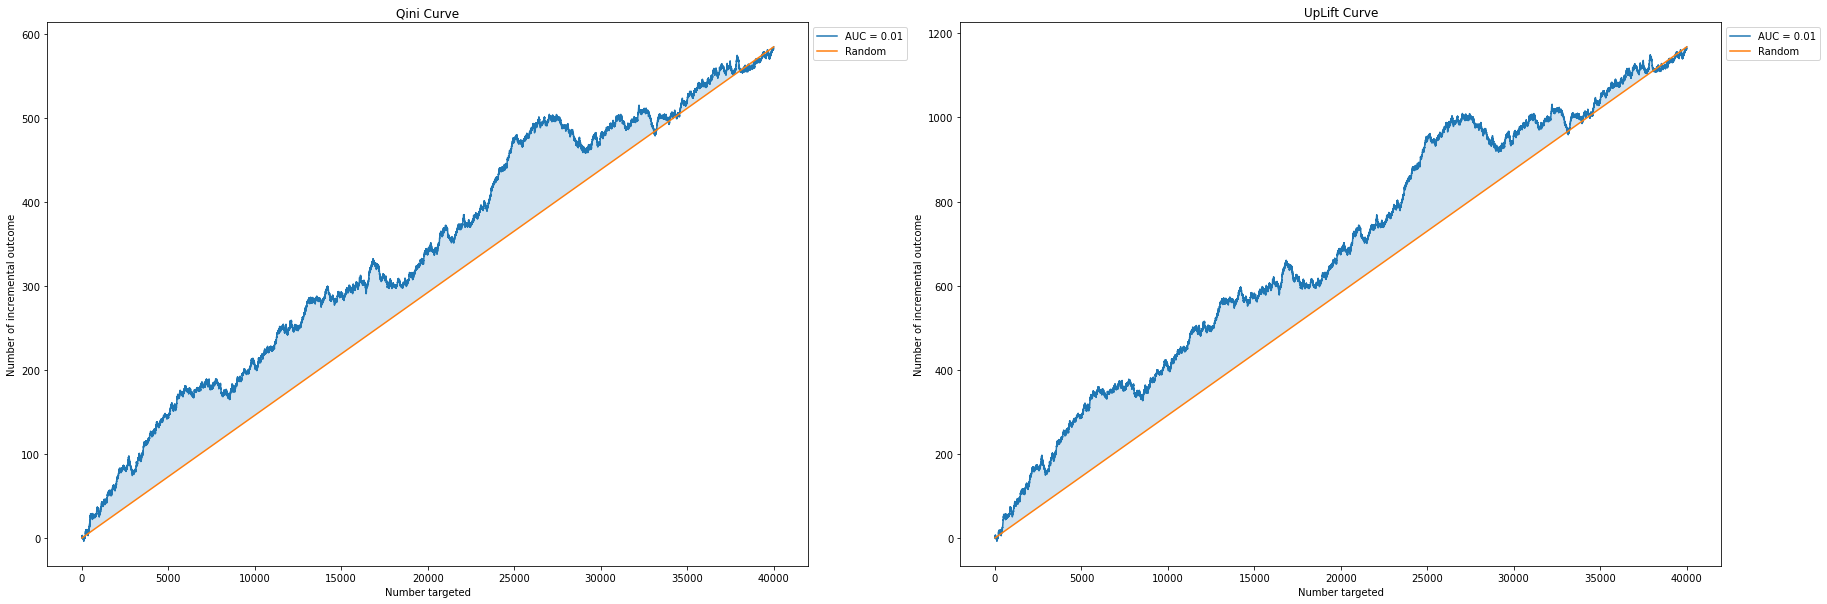

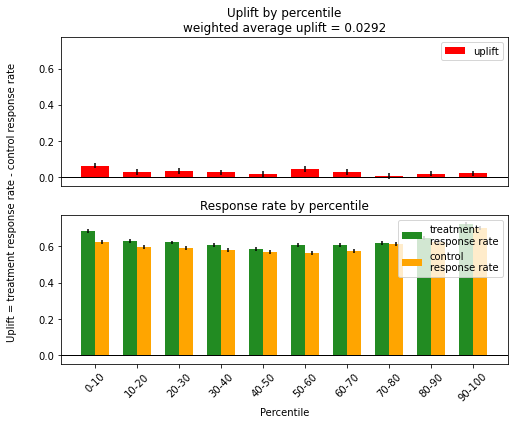

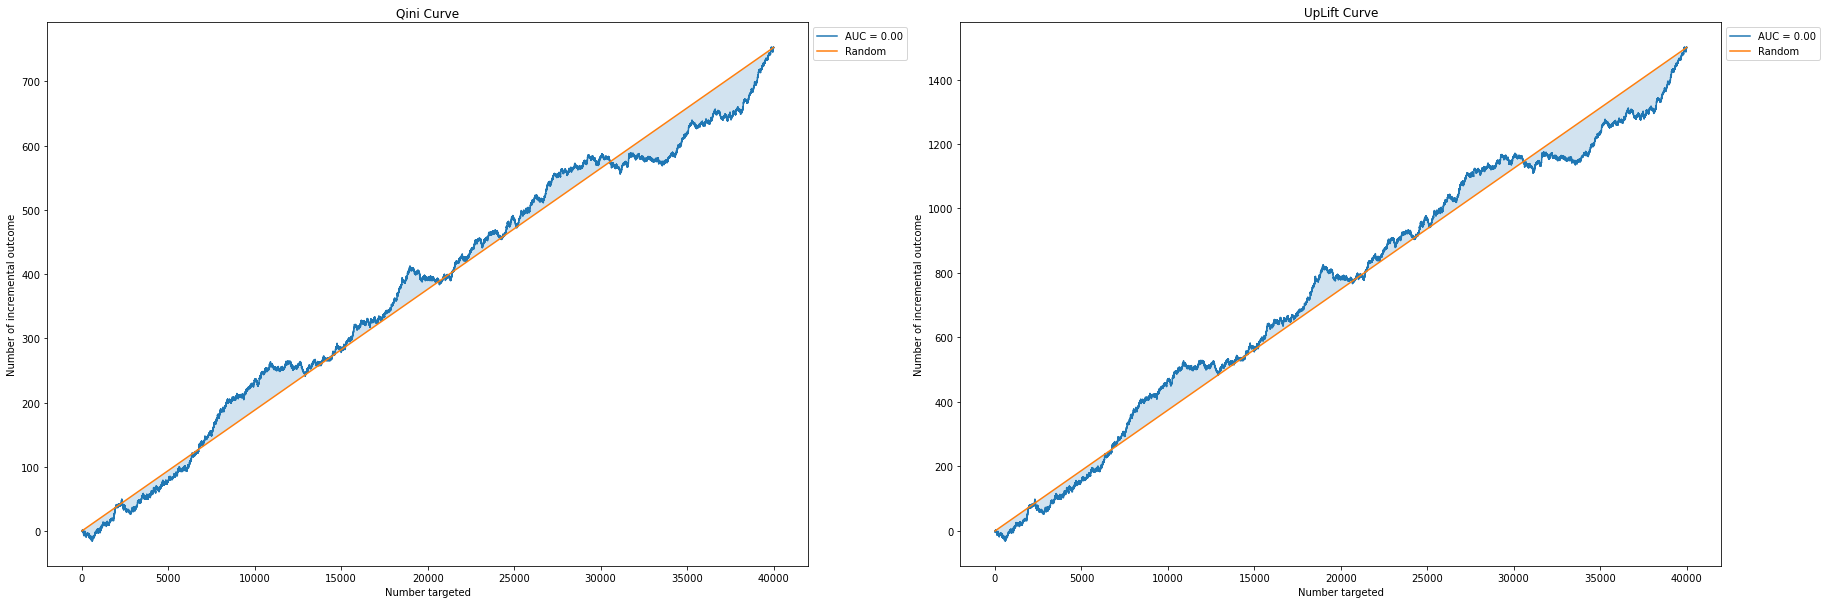

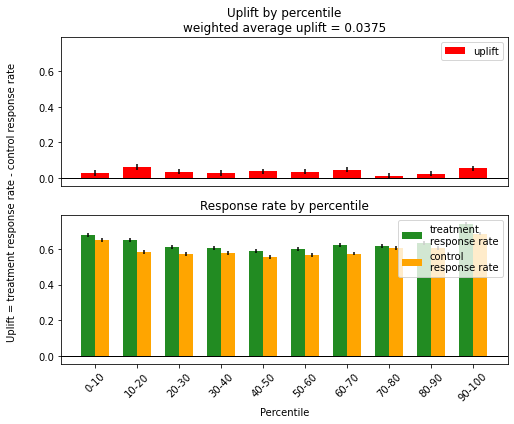

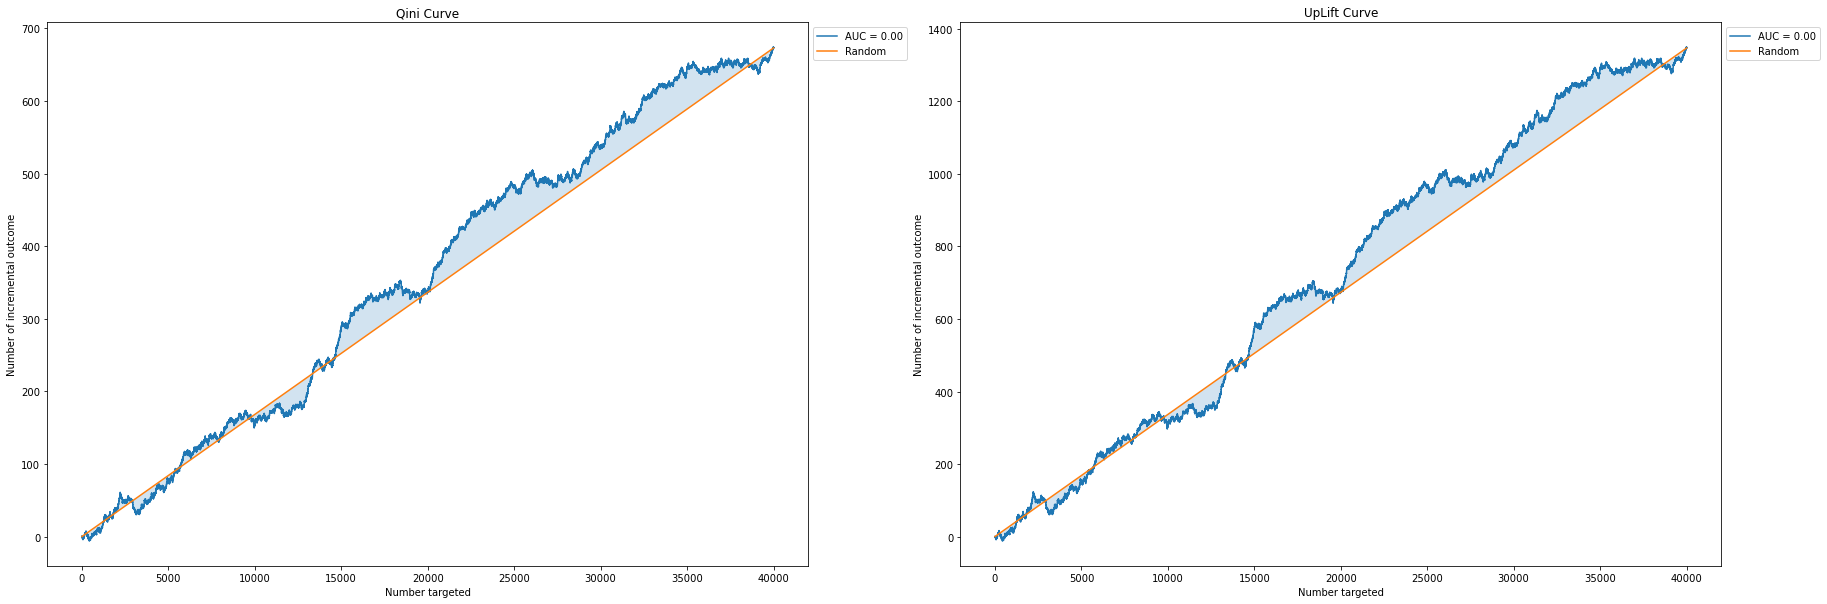

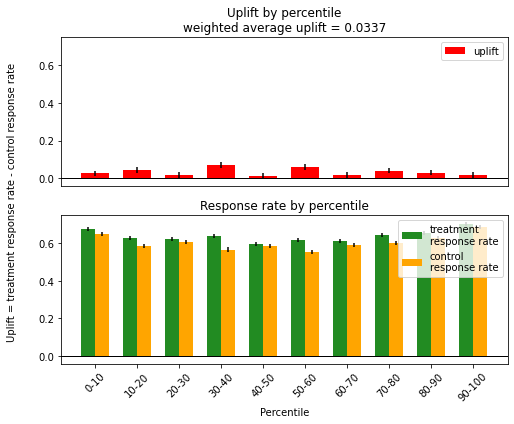

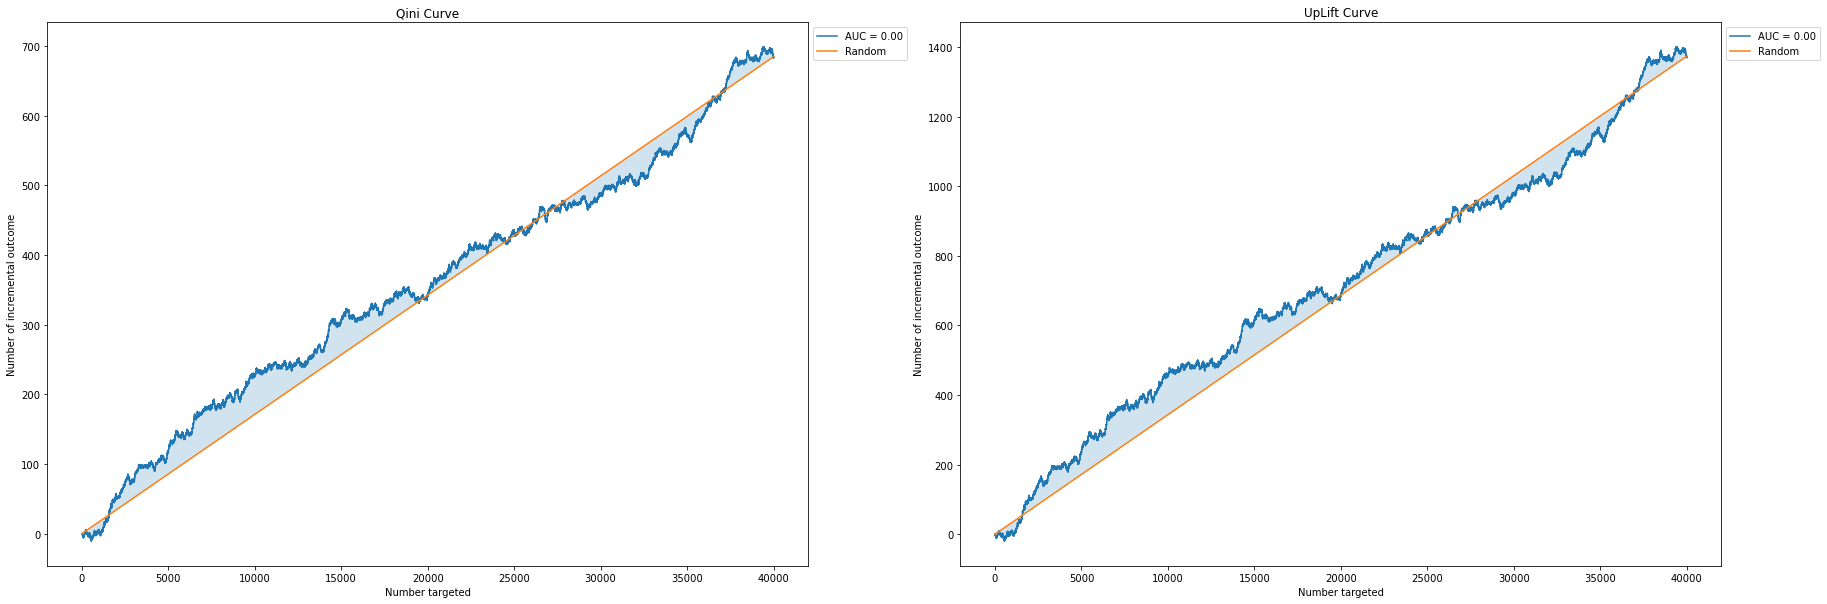

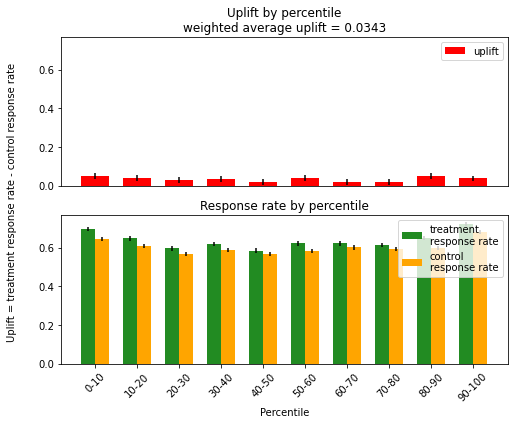

In [47]:
# Метод двух моделей
#Default data
skf = KFold(n_splits=5)
skf.get_n_splits(X, y)
metrics = {'wau':[], 'uplift_k':[]}
i = 0

for train_index, test_index in skf.split(X, y):
      gc.collect()
      X_train_, X_test_ = X[train_index], X[test_index]
      y_train_, y_test_ = y[train_index], y[test_index]
      reg = CatBoostRegressor(verbose=0)
      reg.fit(X_train_, y_train_)
      y_pred = reg.predict(X_test_)
      del reg
      del X_train_
      del y_train_
      del X_test_
      gc.collect()
      wau = weighted_average_uplift(y_true=targ[test_index] , uplift=y_pred,
                              treatment=treat[test_index])
      uplift_overall = uplift_at_k(y_true=targ[test_index] , uplift=y_pred,
                              treatment=treat[test_index], strategy='by_group', k=0.3)
      metrics['wau'].append(wau)
      metrics['uplift_k'].append(uplift_overall)
      i += 1
      print(f'Split {i}; WAU = {wau}; UpLift 30% = {uplift_overall}')
      fig, ax = plt.subplots(1, 2, figsize = (30, 10))
      ax[0].set_title('Qini Curve')
      ax[1].set_title('UpLift Curve')
      plot_qini_curve(y_true=targ[test_index] , uplift=y_pred,
                              treatment=treat[test_index], ax = ax[0], perfect=False)
      gc.collect()
      plot_uplift_curve(y_true=targ[test_index] , uplift=y_pred,
                              treatment=treat[test_index], ax = ax[1], perfect=False)
      gc.collect()
      gc.collect()
      gc.collect()
      plt.savefig(f"Plots/Regression model Split {i}.png")

      plot_uplift_by_percentile(y_true=targ[test_index], uplift=y_pred,
                              treatment=treat[test_index], kind='bar')
      plt.savefig(f"Plots/Regression model Procentile Split {i}.png")


wau = np.round(np.mean(metrics['wau']), 4)
uplift_overall = np.round(np.mean(metrics['uplift_k']), 4)
print(f'Mean WAU = {wau}; Mean UpLift 30% = {uplift_overall}')


In [ ]:
gc.collect()

66278

# AutoML

In [15]:


df= pd.read_csv(r'D:\Documents\GitHub\MastersDegree\Datasets\X5\data\X5_clients_data_train.csv')
med = df.age.median()
df.age = df.age.apply(lambda x: x if((x >= 16) and (x <= 90)) else med)
df.age = df.age.fillna(med)
df.Mean_diffs = df.Mean_diffs.fillna(df.Mean_diffs.median()) 
df = df.fillna(0)
df.describe()
display(df)






df = df.drop(['MeanItemCost', 'NewComerFlag', 'client_id'], axis = 1)
# X = df.iloc[:, 0:-1].set_index('client_id')
# y = df.iloc[:, [0, -1]].set_index('client_id')
# del df
# gc.collect()
treat = df.treatment_flg.values
targ = df.target.values
treat

p = df[df.treatment_flg == 1].shape[0] / df.shape[0]
X = df.iloc[:, 0:-2].values
X = (X - X.mean()) / X.std()
y = df.target * (df.treatment_flg - p) / (1- p) / p
y = y.values
del df
gc.collect()
print(X)
print(y)
print(p)
# X_train, X_test, y_train, y_test = train_test_split(X, y)
# output.enable_custom_widget_manager()
# grid = {'learning_rate':  np.linspace(0, 0.05, 10)[1:-1],
#         'depth': [4, 6, 10],
#         'l2_leaf_reg': [1, 3, 5, 7, 9]}
# clf = CatBoostClassifier(verbose = 0)  
# grid_search_result = clf.grid_search(grid, 
#                                        X=X_train, 
#                                        y=y_train, 
#                                        plot=True)
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt


,client_id,MeanChk,MeanItemCost,Chks,last_chk_ago,Mean_TOP_1_BRAND,Mean_TOP_2_BRAND,Mean_TOP_3_BRAND,Mean_TOP_4_BRAND,Mean_TOP_5_BRAND,...,Mean_TOP_4_LVL,Mean_alc,Mean_CTM,Mean_netto,Mean_diffs,age,NewComerFlag,Gender,treatment_flg,target
0,e2652509f4,300.000000,73.065146,30,4,0.096885,0.085866,0.040000,0.102493,0.131647,...,0.0,0.000000,0.349934,2.714800,3.0,34.0,2,-1,1,0
1,7cef4b564e,192.403846,71.013718,13,4,0.211538,0.064103,0.000000,0.000000,0.201282,...,0.0,0.000000,0.166667,1.507615,8.0,70.0,2,1,1,0
2,1292a2aeae,506.583571,90.585577,14,2,0.079762,0.000000,0.048810,0.081548,0.053571,...,0.0,0.008929,0.135119,2.992000,7.0,58.0,2,0,0,0
3,bbadac1567,1172.320000,72.489040,3,20,0.082935,0.084211,0.000000,0.114514,0.084211,...,0.0,0.000000,0.266507,7.598667,17.0,41.0,0,-1,1,0
4,09c55f2885,137.880000,59.411250,40,0,0.416667,0.023750,0.112917,0.000000,0.000000,...,0.0,0.020833,0.095417,1.060850,2.0,18.0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200034,a04b6cc272,262.096774,116.929800,31,5,0.118280,0.036866,0.043318,0.000000,0.089286,...,0.0,0.000000,0.146352,1.340742,3.0,59.0,2,-1,1,0
200035,f570c011c7,251.000000,88.792803,22,1,0.173485,0.074242,0.056061,0.014773,0.023864,...,0.0,0.136364,0.144697,1.893409,4.0,47.0,2,0,1,1
200036,e7ccdb161f,388.419231,80.784188,13,5,0.102564,0.030342,0.070513,0.023810,0.000000,...,0.0,0.044872,0.156716,1.930462,8.0,55.0,2,-1,1,1
200037,b8464507df,165.374412,84.167661,68,0,0.112815,0.014706,0.010294,0.000000,0.175665,...,0.0,0.031863,0.037885,1.116956,1.0,65.0,2,-1,1,1


[[ 2.40494708e+00  7.92625737e-02 -1.44692231e-01 ... -1.53305877e-01
   1.13717159e-01 -1.87760462e-01]
 [ 1.47815187e+00 -6.71694138e-02 -1.44692231e-01 ... -1.10237645e-01
   4.23808427e-01 -1.70533170e-01]
 [ 4.18438490e+00 -5.85557675e-02 -1.61919523e-01 ... -1.18851292e-01
   3.20444671e-01 -1.79146816e-01]
 ...
 [ 3.16655907e+00 -6.71694138e-02 -1.36078584e-01 ... -1.10237645e-01
   2.94603732e-01 -1.87760462e-01]
 [ 1.24532988e+00  4.06581134e-01 -1.79146816e-01 ... -1.70533170e-01
   3.80740195e-01 -1.87760462e-01]
 [ 1.42971754e+00  1.89670494e-02 -5.85557675e-02 ... -1.44692231e-01
   1.73975679e-03 -1.79146816e-01]]
[ 0.          0.         -0.         ...  2.00077015  2.00077015
 -1.99923045]
0.4998075375301816


In [16]:
import evalml
from evalml import AutoMLSearch

In [17]:
X_train,X_test,y_train,y_test=evalml.preprocessing.split_data(X, y,problem_type='regression')

In [18]:
automl=AutoMLSearch(X_train = X_train
                    , y_train = y_train
                    , n_jobs = -1
                    , problem_type='regression'
                    , verbose = True
                    , allow_long_running_models = True
                    , max_batches = 10
                    , objective = 'Root Mean Squared Error'
                    , optimize_thresholds=True
                    , ensembling=True
                    , max_iterations = 20
                    #, allowed_model_families = evalml.pipelines.components.utils.allowed_model_families('binary')
                    )


automl.search()


*****************************
* Beginning pipeline search *
*****************************

Optimizing for Root Mean Squared Error. 
Lower score is better.

Using SequentialEngine to train and score pipelines.
Searching up to 10 batches for a total of 20 pipelines. 
Allowed model families: 



FigureWidget({
    'data': [{'mode': 'lines+markers',
              'name': 'Best Score',
              'type'…

Evaluating Baseline Pipeline: Mean Baseline Regression Pipeline
Mean Baseline Regression Pipeline:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 1.576

*****************************
* Evaluating Batch Number 1 *
*****************************



c:\Users\Kirill\.conda\envs\automl\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



Elastic Net Regressor w/ Imputer + Standard Scaler:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 1.577


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



Random Forest Regressor w/ Imputer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 1.577


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant




*****************************
* Evaluating Batch Number 2 *
*****************************



c:\Users\Kirill\.conda\envs\automl\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.558e+04, tolerance: 9.889e+00



Elastic Net Regressor w/ Imputer + Standard Scaler + RF Regressor Select From Model:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 1.576


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



Random Forest Regressor w/ Imputer + RF Regressor Select From Model:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 1.577


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant




*****************************
* Evaluating Batch Number 3 *
*****************************

Decision Tree Regressor w/ Imputer + Select Columns Transformer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 1.585


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



Extra Trees Regressor w/ Imputer + Select Columns Transformer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 1.576


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



XGBoost Regressor w/ Imputer + Select Columns Transformer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 1.584


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



CatBoost Regressor w/ Imputer + Select Columns Transformer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 1.576


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



LightGBM Regressor w/ Imputer + Select Columns Transformer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 1.578

*****************************
* Evaluating Batch Number 4 *
*****************************



c:\Users\Kirill\.conda\envs\automl\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant

c:\Users\Kirill\.conda\envs\automl\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.558e+04, tolerance: 9.889e+00



Stacked Ensemble Regression Pipeline:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 1.700


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant




*****************************
* Evaluating Batch Number 5 *
*****************************

CatBoost Regressor w/ Imputer + Select Columns Transformer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 1.658


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



Extra Trees Regressor w/ Imputer + Select Columns Transformer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 1.576


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



Elastic Net Regressor w/ Imputer + Standard Scaler + Select Columns Transformer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 1.576


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



CatBoost Regressor w/ Imputer + Select Columns Transformer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 1.578


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



Extra Trees Regressor w/ Imputer + Select Columns Transformer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 1.576


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



Elastic Net Regressor w/ Imputer + Standard Scaler + Select Columns Transformer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 1.576


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



CatBoost Regressor w/ Imputer + Select Columns Transformer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 1.595


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



Extra Trees Regressor w/ Imputer + Select Columns Transformer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 1.576


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



Elastic Net Regressor w/ Imputer + Standard Scaler + Select Columns Transformer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 1.576

Search finished after 01:13            


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



Best pipeline: CatBoost Regressor w/ Imputer + Select Columns Transformer
Best pipeline Root Mean Squared Error: 1.576281


In [19]:
automl.save('automl_big_searching.cloudpickle')

In [20]:
ranks = automl.rankings
ranks = ranks.drop(['id', 'search_order'	,'mean_cv_score'	,'standard_deviation_cv_score', 'high_variance_cv'], axis = 1)

In [21]:
ranks.to_csv('evalml_res.csv', index = False)

In [22]:
ranks.head()

,pipeline_name,validation_score,percent_better_than_baseline,parameters
0,CatBoost Regressor w/ Imputer + Select Columns...,1.576281,0.002672,{'Imputer': {'categorical_impute_strategy': 'm...
1,Extra Trees Regressor w/ Imputer + Select Colu...,1.576301,0.001389,{'Imputer': {'categorical_impute_strategy': 'm...
3,Elastic Net Regressor w/ Imputer + Standard Sc...,1.576304,0.001186,{'Imputer': {'categorical_impute_strategy': 'm...
5,Mean Baseline Regression Pipeline,1.576323,0.000000,{'Baseline Regressor': {'strategy': 'mean'}}
9,Elastic Net Regressor w/ Imputer + Standard Sc...,1.576488,-0.010503,{'Imputer': {'categorical_impute_strategy': 'm...


In [23]:
ranks.shape

(12, 4)

In [24]:
ranks.head(4).to_excel('res.xlsx')